In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.integrate import odeint
import Library.bfield as bfield
import pandas
import plotly.express as px

ImportError: Unable to import required dependencies:
pytz: No module named 'pytz'

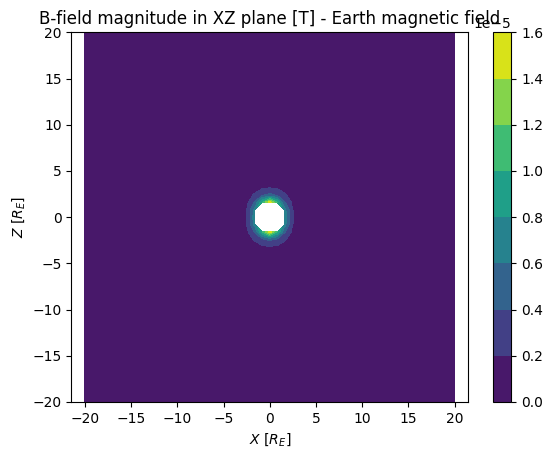

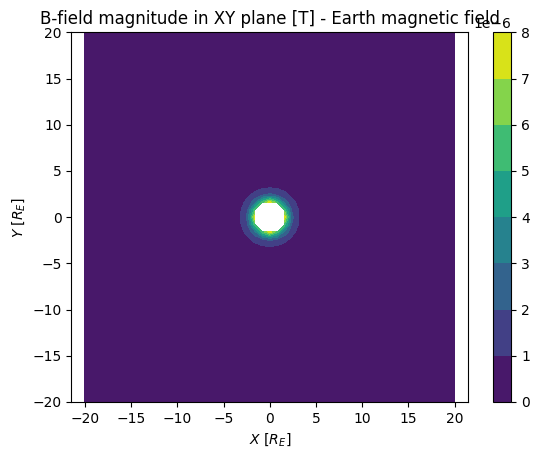

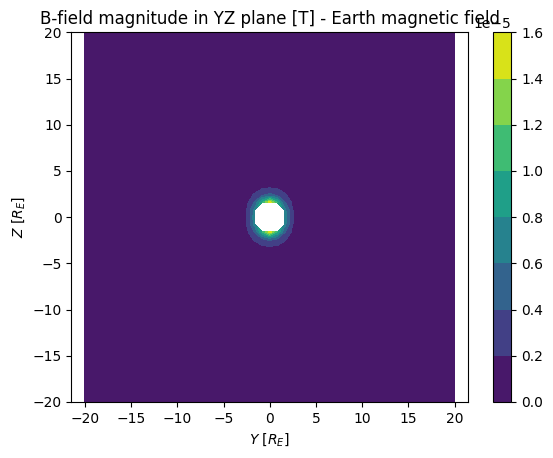

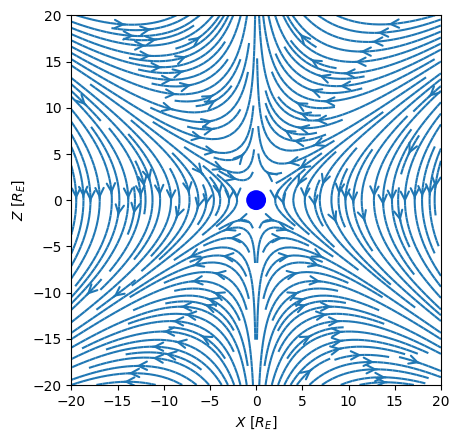

In [192]:
def dipoleEarthSph(r,theta,phi):
    # reference: eq.1-3 https://ccmc.gsfc.nasa.gov/static/files/Dipole.pdf
    M  = -8.e15 # dipole moment of Earth [Tm^3]
    Br = 2.*M*np.cos(theta)/r**3
    Bt =    M*np.sin(theta)/r**3
    Bp = 0.
    return Br,Bt,Bp

def dipoleEarth(x,y,z):
    # reference: eq.1-3 https://ccmc.gsfc.nasa.gov/static/files/Dipole.pdf
    M  = -8.e15 # dipole moment of Earth [Tm^3]
    r = np.sqrt(x**2+y**2+z**2)
    Bx = 3.*M*x*z/r**5
    By = 3.*M*y*z/r**5
    Bz = M*(3.*z*z-r*r)/r**5
    return Bx,By,Bz

def sph2car(r,theta,phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x,y,z

def car2sph(x,y,z):
    x2y2  = x**2 + y**2
    r     = np.sqrt(x2y2 + z**2)
    theta = np.arctan2(np.sqrt(x2y2),z)
    phi   = np.arctan2(y,x)
    return r,theta,phi

# https://stackoverflow.com/questions/4116658/faster-numpy-cartesian-to-spherical-coordinate-conversion
#def appendSpherical_np(xyz):
#    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
#    xy = xyz[:,0]**2 + xyz[:,1]**2
#    ptsnew[:,3] = np.sqrt(xy + xyz[:,2]**2)
#    ptsnew[:,4] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
#    #ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
#    ptsnew[:,5] = np.arctan2(xyz[:,1], xyz[:,0])
#    return ptsnew

def sph2carV(Ar,At,Ap,r,theta,phi):
    T = ([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi), np.cos(theta)],
         [np.cos(theta)*np.cos(phi),np.cos(theta)*np.sin(phi),-np.sin(theta)],
         [             -np.sin(phi),              np.cos(phi),             0])
    xyz = np.matmul(np.transpose(T),(Ar,At,Ap))
    Ax,Ay,Az = np.transpose(xyz)
    #Ax = np.sin(theta)*np.cos(phi)*Ar+np.cos(theta)*np.cos(phi)*At-np.sin(phi)*Ap
    #Ay = np.sin(theta)*np.sin(phi)*Ar+np.cos(theta)*np.sin(phi)*At+np.cos(phi)*Ap
    #Az =             np.cos(theta)*Ar            -np.sin(theta)*At
    #x, y, z  = sph2car(r,theta,phi)
    return Ax,Ay,Az#,x,y,z

def car2sphV(Ax,Ay,Az,x,y,z):
    r,theta,phi = car2sph(x,y,z)
    T = ([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi), np.cos(theta)],
         [np.cos(theta)*np.cos(phi),np.cos(theta)*np.sin(phi),-np.sin(theta)],
         [             -np.sin(phi),              np.cos(phi),             0])
    rtp = np.matmul(T,(Ax,Ay,Az))
    Ar,Atheta,Aphi     = np.transpose(rtp)
    return Ar,Atheta,Aphi#,r,theta,phi

def main():
    RE = 6.371e6 # Earth radius [m]
    Nx = 51
    Ny = 51
    Nz = 51
    #r     = np.linspace( RE,   20.*RE, Nr )
    #theta = np.linspace( 0.,    np.pi, Nt )
    #phi   = np.linspace( 0., 2.*np.pi, Np )
    x = np.linspace( -20.*RE, 20.*RE, Nx)
    y = np.linspace( -20.*RE, 20.*RE, Ny)
    z = np.linspace( -20.*RE, 20.*RE, Nz)
    
    Bmag = np.empty((Nx,Ny,Nz))
    Bx   = np.empty((Nx,Ny,Nz))
    By   = np.empty((Nx,Ny,Nz))
    Bz   = np.empty((Nx,Ny,Nz))
    
    Bmagc = np.empty((Nx,Ny,Nz))
    Bxc   = np.empty((Nx,Ny,Nz))
    Byc   = np.empty((Nx,Ny,Nz))
    Bzc   = np.empty((Nx,Ny,Nz))
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(0,Nz):
                if abs(x[i])<RE and abs(y[j])<RE and abs(z[k])<RE:
                    Bmagc[i,j,k] = np.nan
                    Bxc[i,j,k]   = np.nan
                    Byc[i,j,k]   = np.nan
                    Bzc[i,j,k]   = np.nan
                else:
                    Bxc[i,j,k],Byc[i,j,k],Bzc[i,j,k] = dipoleEarth(x[i],y[j],z[k])
                    Bmagc[i,j,k] = np.sqrt( Bxc[i,j,k]**2 + Byc[i,j,k]**2 + Bzc[i,j,k]**2 )
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(0,Nz):
                if abs(x[i])<RE and abs(y[j])<RE and abs(z[k])<RE:
                    Bmag[i,j,k] = np.nan
                    Bx[i,j,k]   = np.nan
                    By[i,j,k]   = np.nan
                    Bz[i,j,k]   = np.nan
                else:
                    r,theta,phi = car2sph( x[i],y[j],z[k] )
                    Br,Bt,Bp    = dipoleEarthSph( r,theta,phi )
                    #Bx[i,j,k],By[i,j,k],Bz[i,j,k] = sph2car(Br,Bt,Bp)
                    Bx[i,j,k],By[i,j,k],Bz[i,j,k] = sph2carV(Br,Bt,Bp,r,theta,phi)
                    Bmag[i,j,k] = np.sqrt( Bx[i,j,k]**2 + By[i,j,k]**2 + Bz[i,j,k]**2 )
    
    plt.figure(1)
    xx,zz = np.meshgrid(x,z)
    plt.contourf(np.transpose(xx)/RE,np.transpose(zz)/RE, Bmag[:,25,:])
    plt.xlabel('$X$ [$R_E$]')
    plt.ylabel('$Z$ [$R_E$]')
    plt.axis('equal')
    plt.colorbar()
    plt.title('B-field magnitude in XZ plane [T] - Earth magnetic field')
    plt.savefig('dipoleEarth_XZ.png',dpi=150)
    plt.show()
    
    plt.figure(2)
    xx,yy = np.meshgrid(x,y)
    plt.contourf(np.transpose(xx)/RE,np.transpose(yy)/RE, Bmag[:,:,25])
    plt.xlabel('$X$ [$R_E$]')
    plt.ylabel('$Y$ [$R_E$]')
    plt.axis('equal')
    plt.colorbar()
    plt.title('B-field magnitude in XY plane [T] - Earth magnetic field')
    plt.savefig('dipoleEarth_XY.png',dpi=150)
    plt.show()
    
    plt.figure(3)
    yy,zz = np.meshgrid(y,z)
    plt.contourf(np.transpose(yy)/RE,np.transpose(zz)/RE, Bmag[25,:,:])
    plt.xlabel('$Y$ [$R_E$]')
    plt.ylabel('$Z$ [$R_E$]')
    plt.axis('equal')
    plt.colorbar()
    plt.title('B-field magnitude in YZ plane [T] - Earth magnetic field')
    plt.savefig('dipoleEarth_YZ.png',dpi=150)
    plt.show()
    
    # https://scipython.com/blog/visualizing-a-vector-field-with-matplotlib/
    fig = plt.figure(4)
    ax = fig.add_subplot(111)
    #Bx_fl = np.empty((Nz,Nx))
    #Bz_fl = np.empty((Nz,Nx))
    #for i in range(0,Nx):
    #    for j in range(0,Nz):
    #        Bx_fl[j,i] = Bx[i,25,j]/Bmag[i,25,j]
    #        Bz_fl[j,i] = Bz[i,25,j]/Bmag[i,25,j]
    #color = 2 * np.log(np.hypot(Bx_fl, Bz_fl))
    
    ax.streamplot(x/RE,z/RE,Bx[:,25,:],Bz[:,25,:],# color=color,linewidth=1, cmap=plt.cm.inferno,
              density=2, arrowstyle='->', arrowsize=1.5)
    ax.add_artist(Circle((0,0), 1, color='b'))
    plt.xlabel('$X$ [$R_E$]')
    plt.ylabel('$Z$ [$R_E$]')
    ax.set_aspect('equal')

if __name__ == '__main__':
   main()

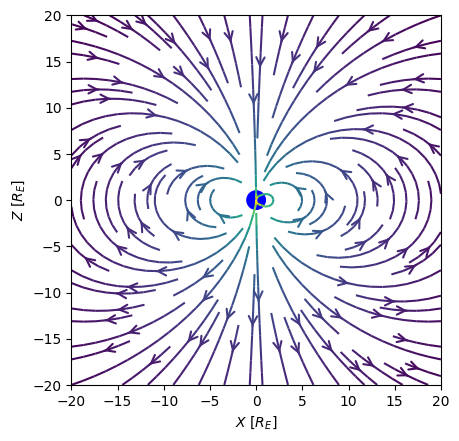

In [183]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def dipoleEarthXZ(x,z):
    # reference: eq.1-3 https://ccmc.gsfc.nasa.gov/static/files/Dipole.pdf
    M  = -8e15 # dipole moment of Earth [Tm^3]
    #sph2car()
    r = np.sqrt(x**2+z**2)
    Bx = 3.*M*x*z/r**5
    #By = 3.*M*y*z/r**5
    Bz = M*(3.*z*z-r*r)/r**5
    return Bx,Bz

# Grid of x, y points
RE = 6.371e6
Nx, Nz = 100,100
x = np.linspace(-20.*RE, 20.*RE, Nx)
z = np.linspace(-20.*RE, 20.*RE, Nz)
X, Z = np.meshgrid(x, z)

# Electric field vector, E=(Ex, Ey), as separate components
Bx, Bz = np.zeros((Nz, Nx)), np.zeros((Nz, Nx))
Bx, Bz = dipoleEarthXZ(x=X, z=Z)

fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the streamlines with an appropriate colormap and arrow style
color = 2 * np.log(np.hypot(Bx, Bz))
ax.streamplot(x/RE, z/RE, Bx, Bz, color=color,arrowstyle='->', arrowsize=1.5)
ax.add_artist(Circle((0,0), 1, color='b'))

ax.set_xlabel('$X$ [$R_E$]')
ax.set_ylabel('$Z$ [$R_E$]')
ax.set_aspect('equal')
plt.show()